In [1]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from hfnet.datasets.colmap import Colmap
from hfnet.evaluation.loaders import sift_loader, export_loader, fast_loader, harris_loader
from hfnet.evaluation.local_descriptors import evaluate
from hfnet.utils import tools

from utils import plot_images

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
config = {
    'sequences': [
        'british_museum',
#        'florence_cathedral_side',
#        'lincoln_memorial_statue', 
        'london_bridge',
        'milan_cathedral',
        'mount_rushmore',
        'piazza_san_marco',
        'reichstag',
#        'sagrada_familia',
        'st_pauls_cathedral',
#        'united_states_capitol'
    ],
    'make_pairs': True, 'shuffle': True, 'pair_thresh': 0.4, 'max_num_pairs': 50
}
dataset = Colmap(**config)

[10/20/2018 12:58:56 INFO] Colmap sequence british_museum contains 50 pairs
[10/20/2018 12:59:05 INFO] Colmap sequence london_bridge contains 50 pairs
[10/20/2018 12:59:07 INFO] Colmap sequence milan_cathedral contains 50 pairs
[10/20/2018 12:59:08 INFO] Colmap sequence mount_rushmore contains 50 pairs
[10/20/2018 12:59:12 INFO] Colmap sequence piazza_san_marco contains 50 pairs
[10/20/2018 12:59:13 INFO] Colmap sequence reichstag contains 50 pairs
[10/20/2018 12:59:21 INFO] Colmap sequence st_pauls_cathedral contains 50 pairs


In [44]:
config = {
    'id': 'sift_ratio_root',
    'predictor': sift_loader,
    'root': True,
    'num_features': 1000,
    'do_ratio_test': True,
    'do_nms': False,
    'nms_thresh': 4,
}

In [39]:
config = {
    'id': 'superpoint_ratio_nms-8',
    'experiment': 'super_point_pytorch/colmap',
    'predictor': export_loader,
    'num_features': 1000,
#    'keypoint_predictor': harris_loader,
#    'keypoint_config': {
#        'do_nms': True,
#        'nms_thresh': 4,
#    },
    'do_nms': True,
    'nms_thresh': 8,
    'do_ratio_test': True,
    'binarize': False,
}

In [10]:
config = {
    'id': 'doap_ST-dense_hpatches_superpoint_nms-8_ratio',
    'experiment': 'doap/colmap_hpatches_ST-dense',
    'predictor': export_loader,
    'keypoint_predictor': export_loader,
    'keypoint_config': {
        'experiment': 'super_point_pytorch/colmap',
        'do_nms': True,
        'nms_thresh': 8,
    },
    'num_features': 1000,
    'do_ratio_test': True,
}

In [101]:
config = {
    'id': 'netvlad_conv3-3_dist_1000-kpts-sp',
    'experiment': 'netvlad/colmap',
    'predictor': export_loader,
    'num_features': 1000,
    'keypoint_predictor': export_loader,
    'keypoint_config': {
        'experiment': 'super_point_pytorch/colmap_all',
        'do_nms': True,
        'nms_thresh': 4,
    },
    'do_ratio_test': False,
    'binarize': False,
}

In [142]:
config = {
    'id': 'mobilenetvlad_L-14_dist_1000-kpts-sp',
    'experiment': 'mobilenetvlad_depth-0.35/colmap_layer-14',
    'predictor': export_loader,
    'num_features': 1000,
    'keypoint_predictor': export_loader,
    'keypoint_config': {
        'experiment': 'super_point_pytorch/colmap_all',
        'do_nms': True,
        'nms_thresh': 4,
    },
    'do_ratio_test': False,
}

In [25]:
config = {
    'id': 'lfnet_dist',
    'experiment': 'lfnet/colmap_all_kpts-1000',
    'predictor': export_loader,
    'num_features': 1000,
    'do_ratio_test': False,
    'do_nms': False,
    'nms_thresh': 4,
}

In [9]:
all_configs = {
    'sift_ratio_root': {
        'predictor': sift_loader,
        'root': True,
        'num_features': 1000,
        'do_ratio_test': True,
        'do_nms': False,
        'nms_thresh': 4,
    },
    'superpoint_ratio_nms-8': {
        'experiment': 'super_point_pytorch/colmap',
        'predictor': export_loader,
        'num_features': 1000,
        #    'keypoint_predictor': harris_loader,
        #    'keypoint_config': {
        #        'do_nms': True,
        #        'nms_thresh': 4,
        #    },
        'do_nms': True,
        'nms_thresh': 8,
        'do_ratio_test': True,
        'binarize': False,
    },
    'doap_hpatches_sp_nms-8_ratio': {
        'experiment': 'doap/colmap_hpatches_ST-dense',
        'predictor': export_loader,
        'keypoint_predictor': export_loader,
        'keypoint_config': {
            'experiment': 'super_point_pytorch/colmap',
            'do_nms': True,
            'nms_thresh': 8,
        },
        'num_features': 1000,
    'do_ratio_test': True,
    },
    'netvlad_conv3-3_dist_1000-kpts-sp': {
        'experiment': 'netvlad/colmap',
        'predictor': export_loader,
        'num_features': 1000,
        'keypoint_predictor': export_loader,
        'keypoint_config': {
            'experiment': 'super_point_pytorch/colmap',
            'do_nms': True,
            'nms_thresh': 8,
        },
        'do_ratio_test': False,
    'binarize': False,
    },
}
eval_config = {
    'correct_match_thresh': 5,
    'correct_trans_thresh': 1,
    'correct_rot_thresh': 1,
    'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]
}

In [ ]:
methods = ['superpoint_ratio_nms-8', 'sift_ratio_root',
           'doap_hpatches_sp_nms-8_ratio', 'netvlad_conv3-3_dist_1000-kpts-sp']
configs = {m: all_configs[m] for m in methods}
pose_recalls, nn_pr = {}, {}
for method, config in configs.items():
    config = tools.dict_update(config, eval_config)
    data_iter = dataset.get_test_set()
    metrics, nn_precision, nn_recall, distances, pose_recall = evaluate(data_iter, config, is_2d=False)
    
    print('> {}'.format(method))
    for k, v in metrics.items():
        print('{:<25} {:.3f}'.format(k, v))
    print(config)
    
    pose_recalls[method] = pose_recall
    nn_pr[method] = (nn_precision, nn_recall, distances)

350it [01:14,  7.62it/s]
0it [00:00, ?it/s]

> superpoint_ratio_nms-8
average_num_keypoints     692.517
matching_score            0.379
mAP                       0.443
{'experiment': 'super_point_pytorch/colmap', 'predictor': <function export_loader at 0x2ae219a5b8c8>, 'num_features': 1000, 'do_nms': True, 'nms_thresh': 8, 'do_ratio_test': True, 'binarize': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


350it [02:11,  3.17it/s]
0it [00:00, ?it/s]

> sift_ratio_root
average_num_keypoints     1000.000
matching_score            0.201
mAP                       0.225
{'predictor': <function sift_loader at 0x2ae219a72e18>, 'root': True, 'num_features': 1000, 'do_ratio_test': True, 'do_nms': False, 'nms_thresh': 4, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


350it [02:09,  2.48it/s]
0it [00:00, ?it/s]

> doap_hpatches_sp_nms-8_ratio
average_num_keypoints     692.517
matching_score            0.408
mAP                       0.513
{'experiment': 'doap/colmap_hpatches_ST-dense', 'predictor': <function export_loader at 0x2ae219a5b8c8>, 'keypoint_predictor': <function export_loader at 0x2ae219a5b8c8>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap', 'do_nms': True, 'nms_thresh': 8, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


287it [03:13,  1.76it/s]

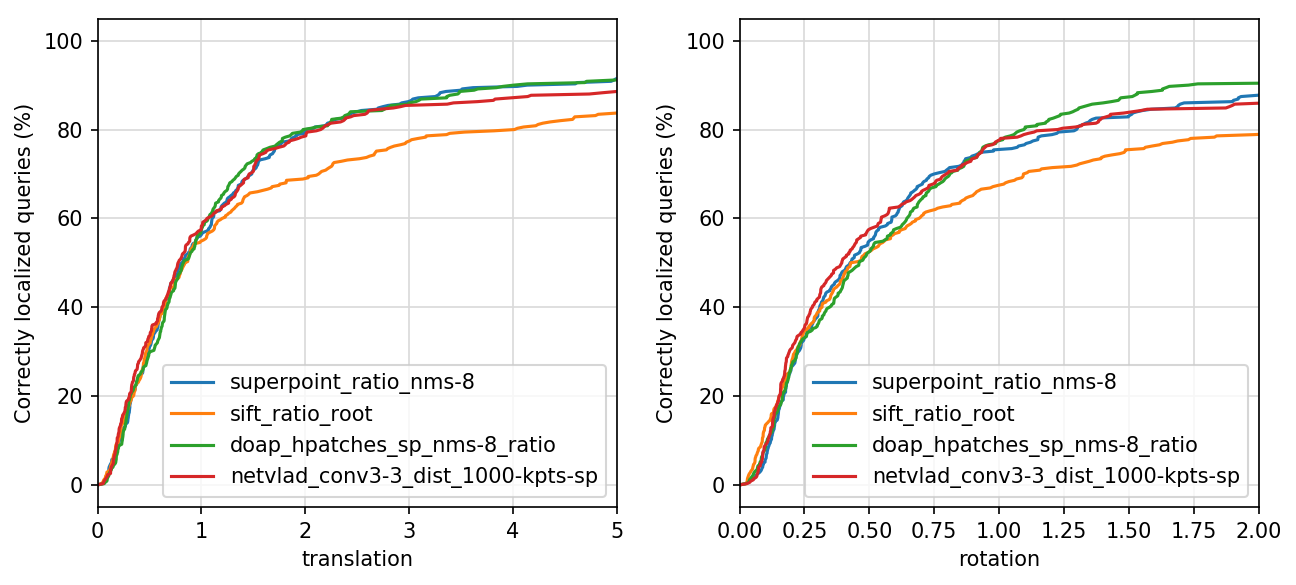

In [21]:
error_names = list(list(pose_recalls.values())[0].keys())
expers = list(pose_recalls.keys())
lim = {'translation': 5, 'rotation': 2}

f, axes = plt.subplots(1, len(error_names), figsize=(8, 4), dpi=150)
for error_name, ax in zip(error_names, axes):
    for exper in expers:
        steps, recall = pose_recalls[exper][error_name]
        ax.set_xlim([0, lim[error_name]])
        ax.plot(steps, recall*100, label=exper);
    ax.grid(color=[0.85]*3);
    ax.set_xlabel(error_name);
    ax.set_ylabel('Correctly localized queries (%)');
    ax.legend(loc=4); 
plt.tight_layout()
plt.gcf().subplots_adjust(left=0);

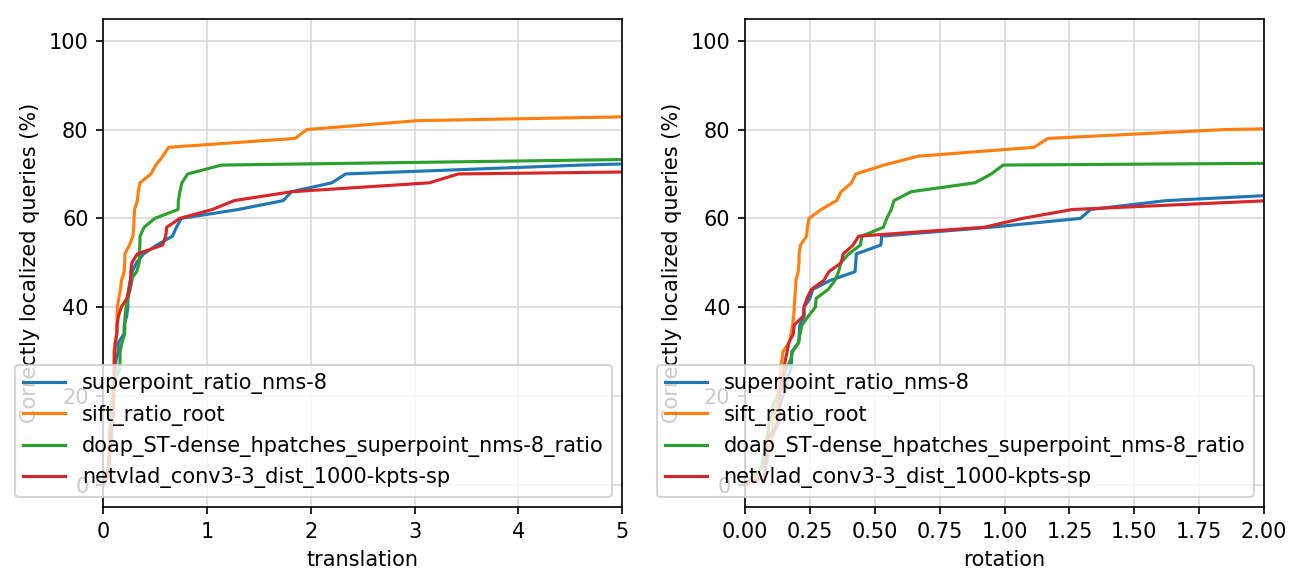

In [5]:
'sagrada'

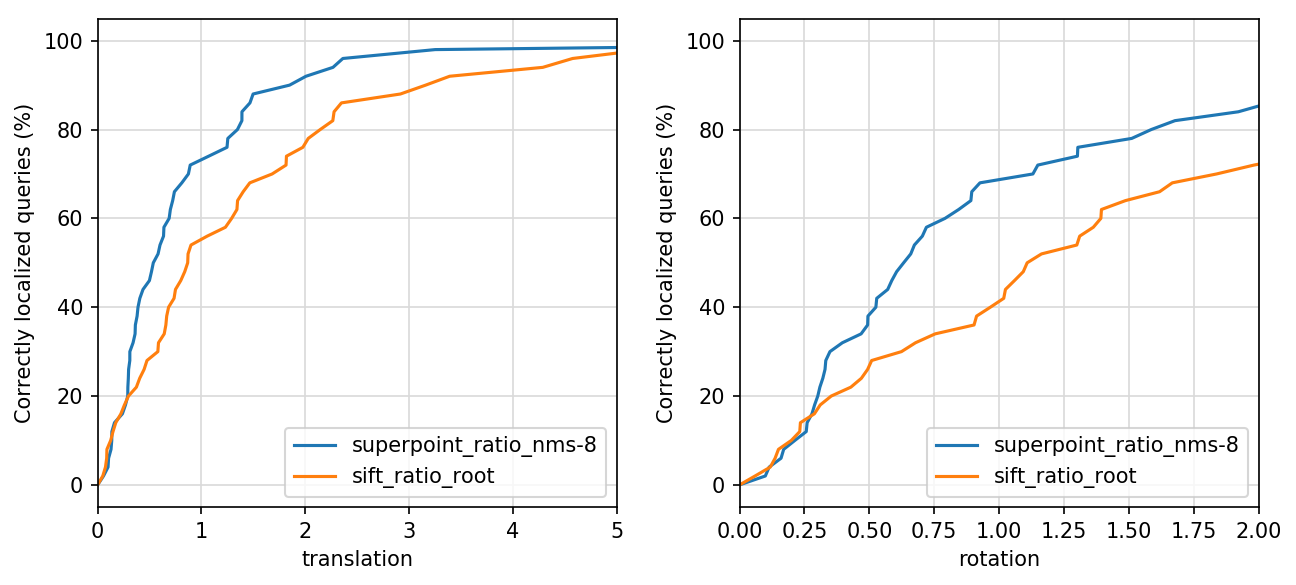

In [45]:
'british_museum'

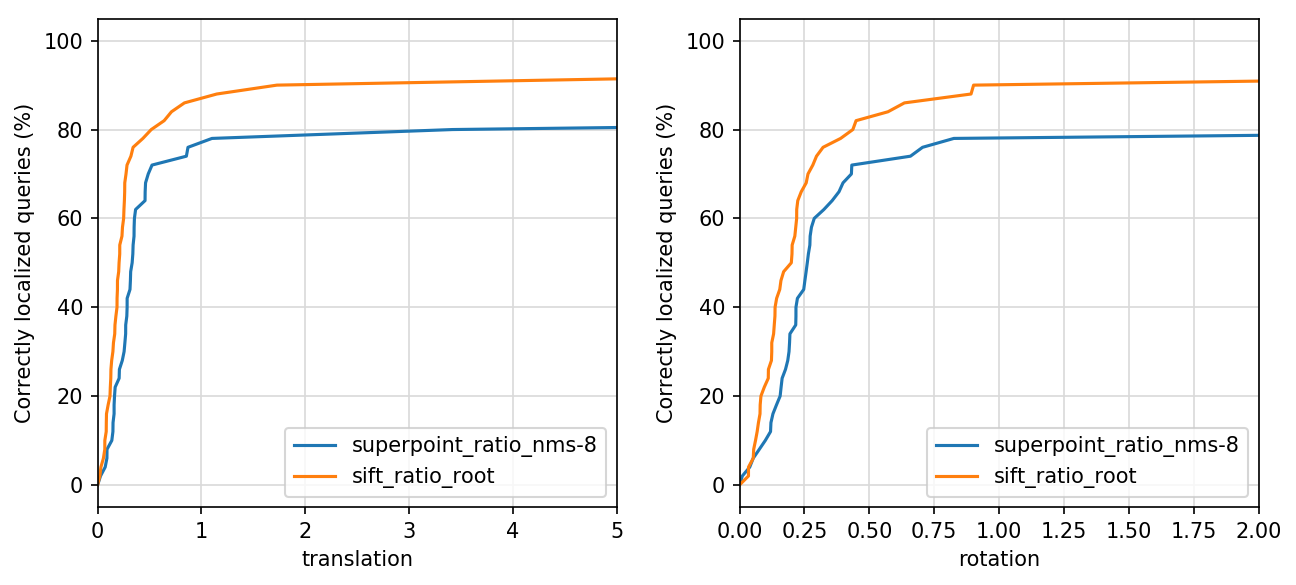

In [41]:
'florence_cathedral_side'

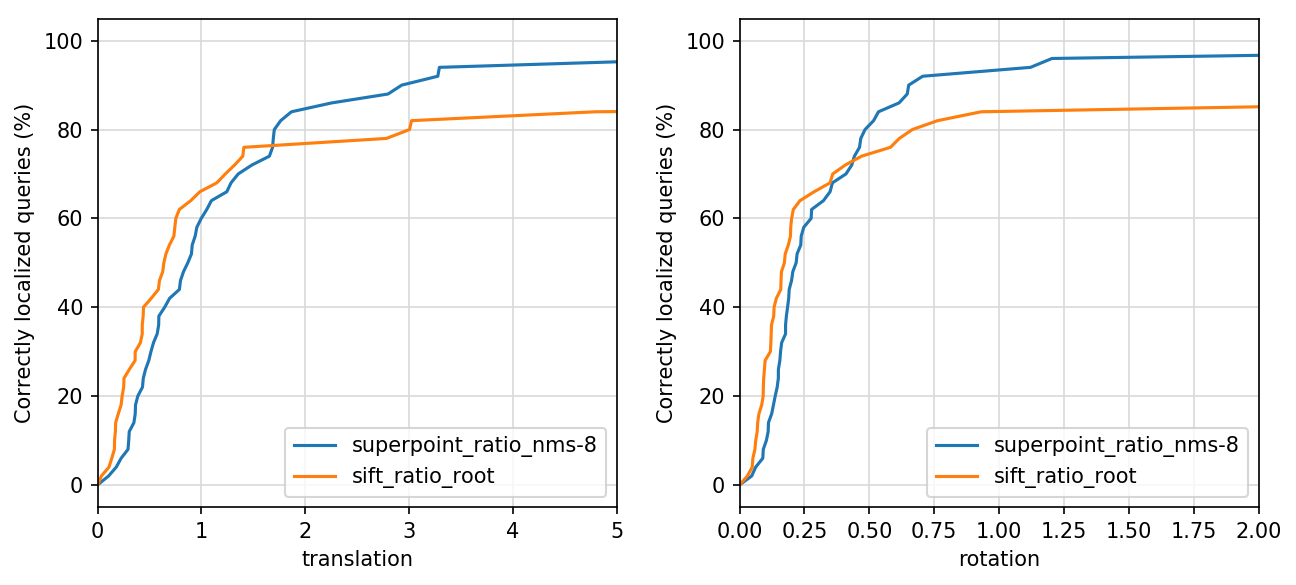

In [37]:
'london_bridge'

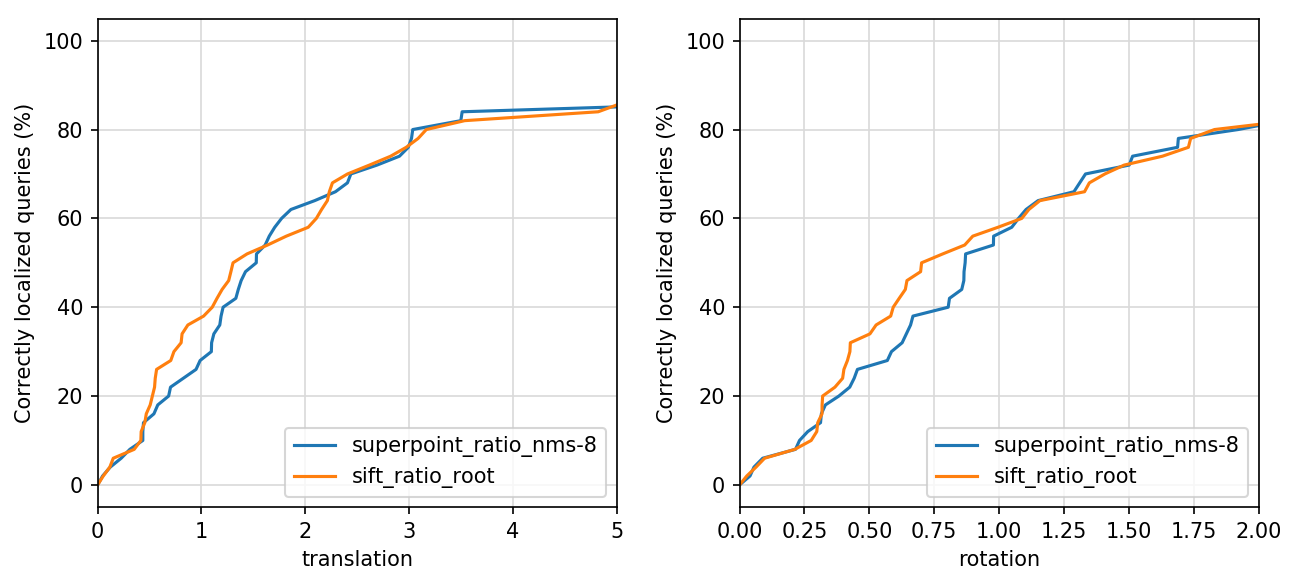

In [34]:
'milan_cathedral'

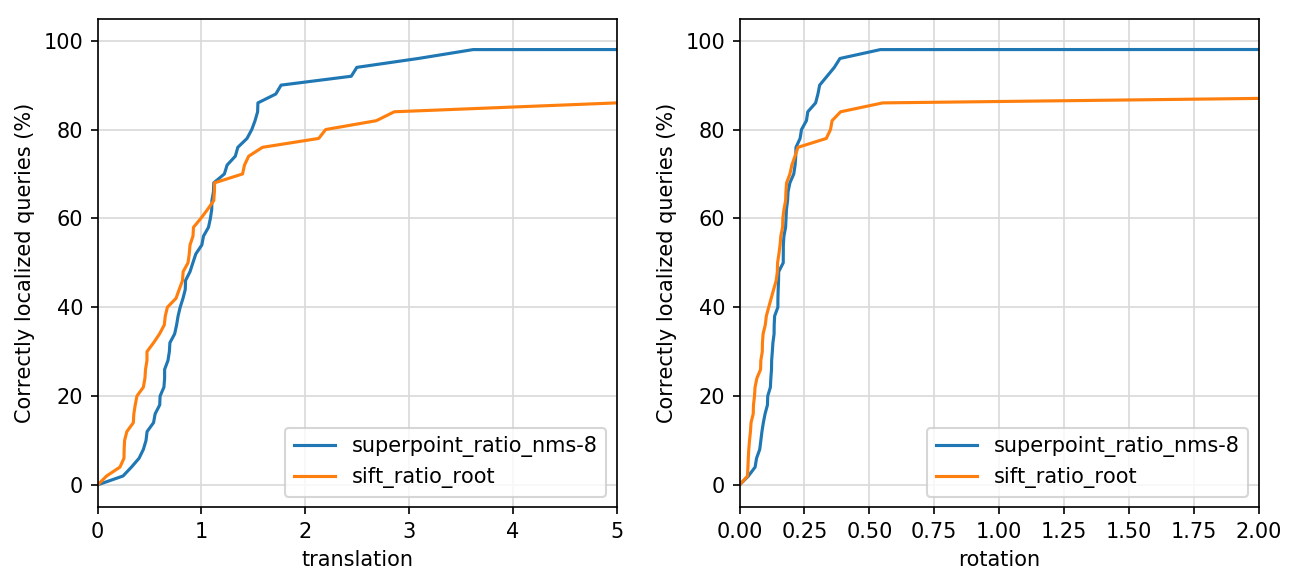

In [31]:
'mount_rushmore'

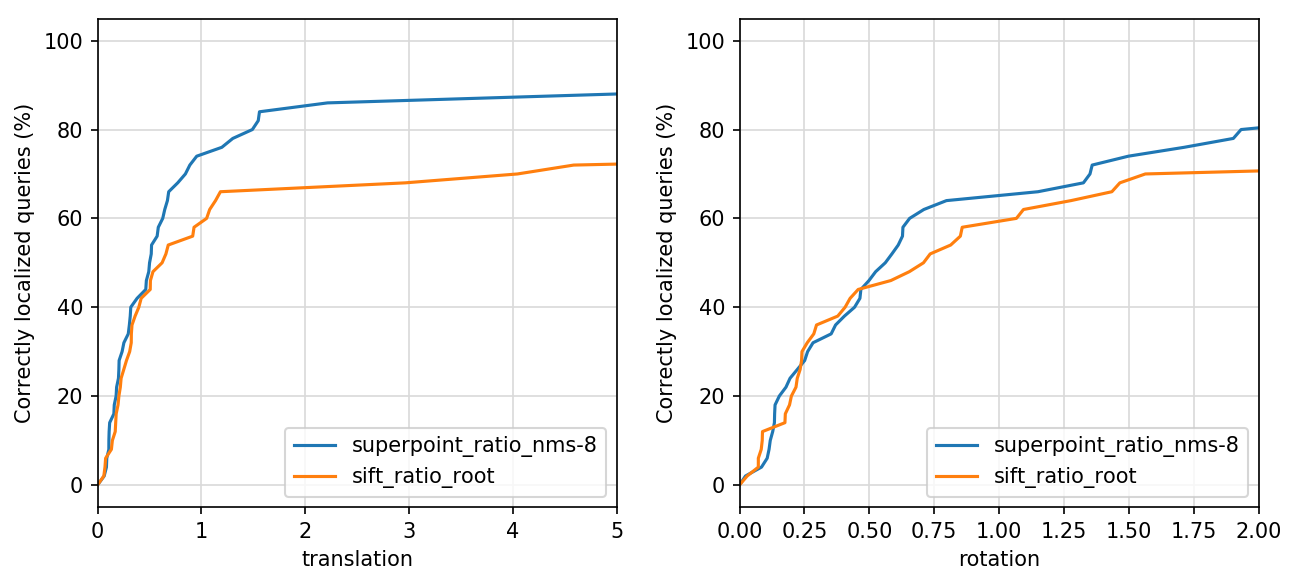

In [25]:
'piazza_san_marco'

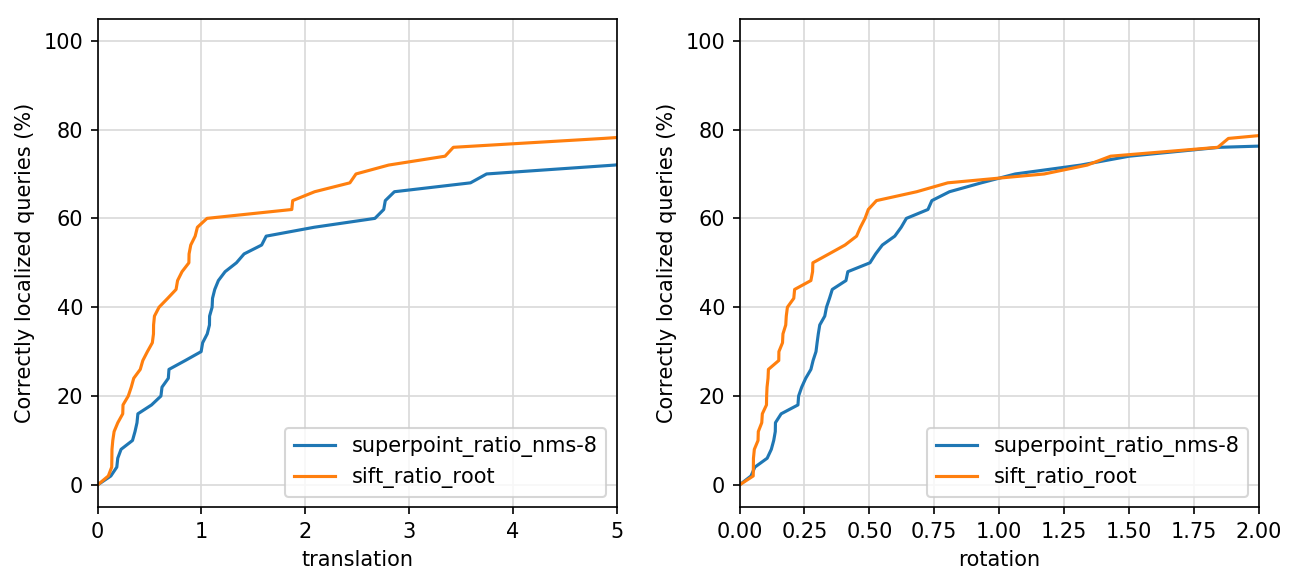

In [22]:
'united_states_capitol'

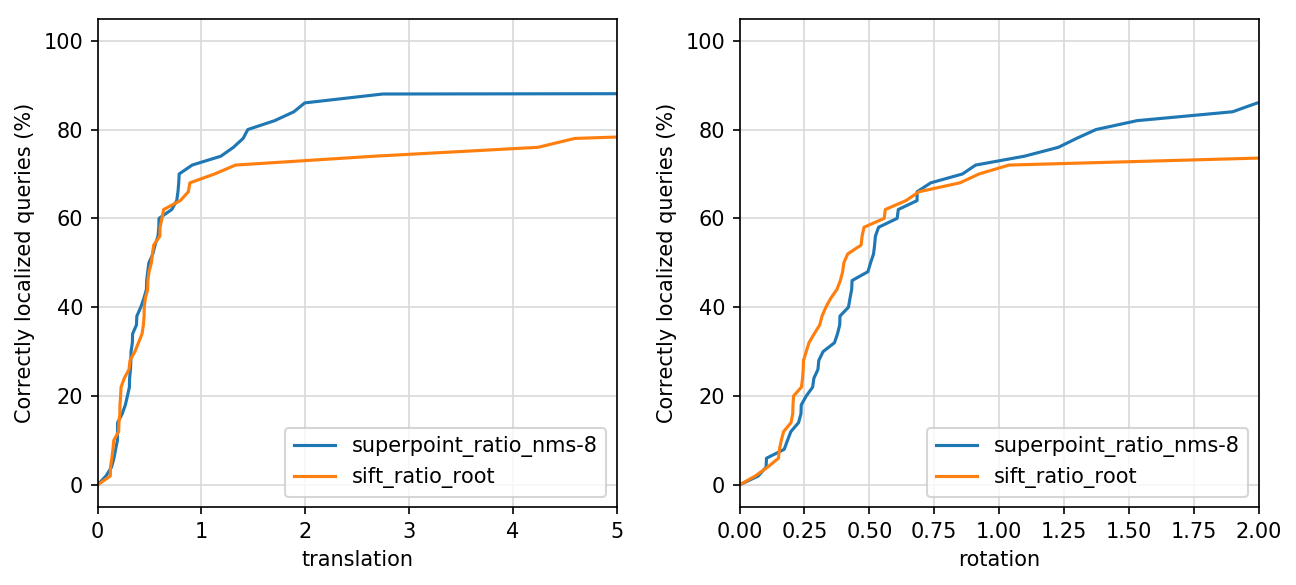

In [18]:
'st_pauls_cathedral'

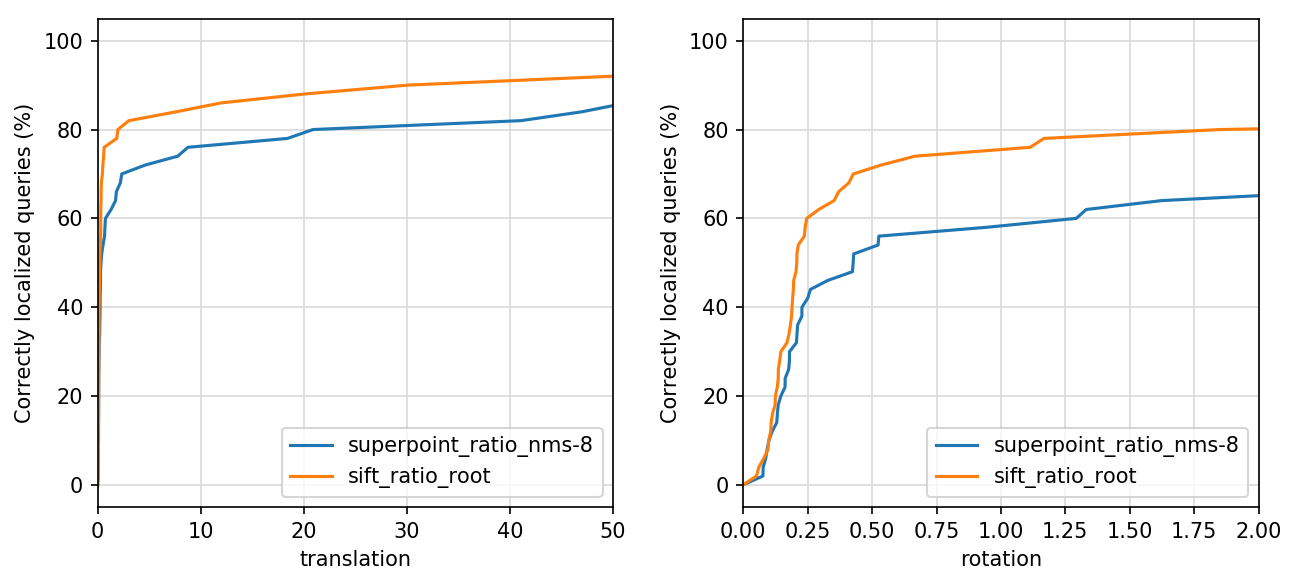

In [13]:
'sagrada'

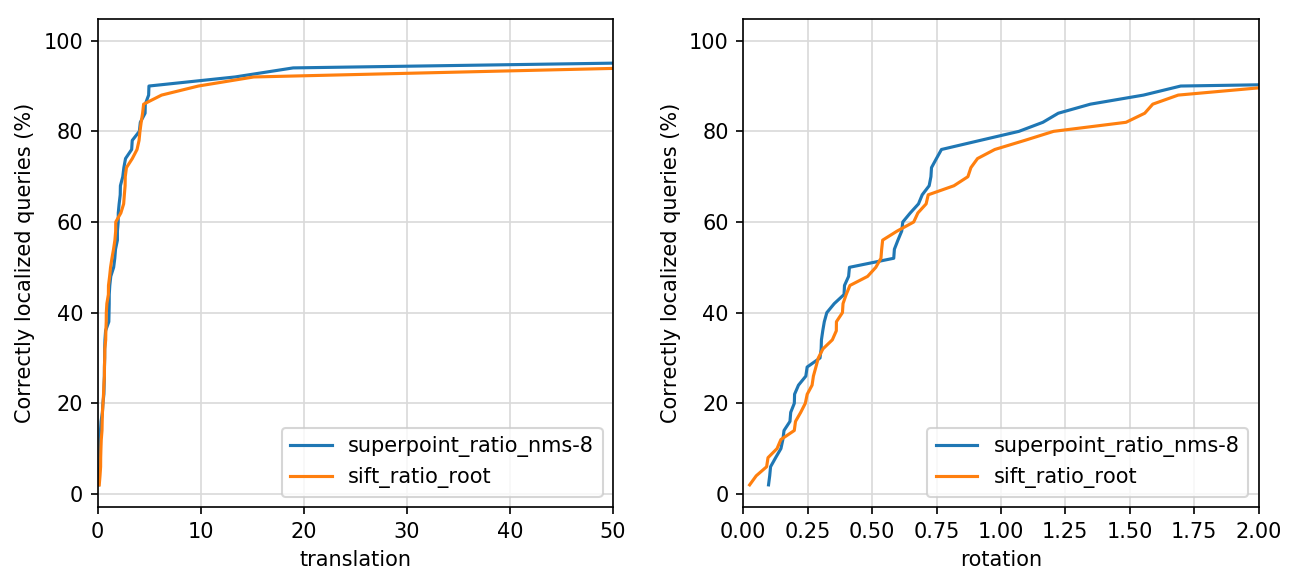

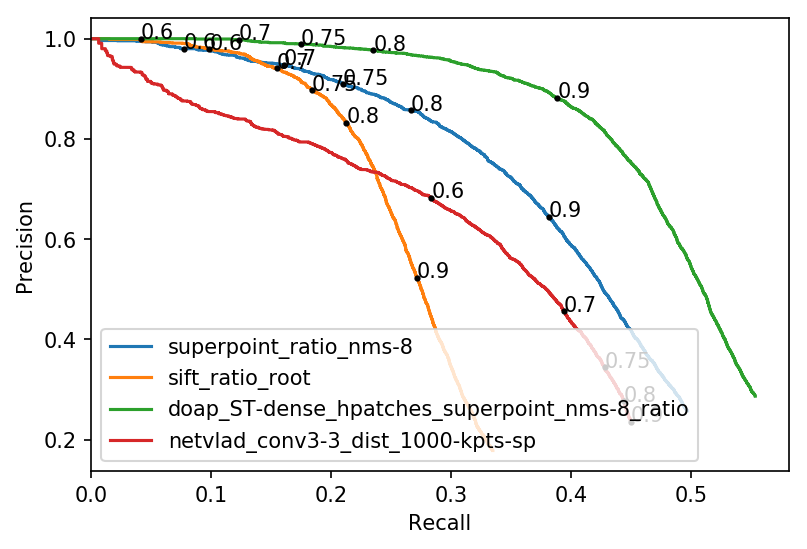

In [6]:
plt.figure(dpi=150, figsize=(6, 4));
for exper, (precision, recall, distances) in nn_pr.items():
    plt.plot(recall, precision, label=exper);

    for t in eval_config['plot_match_thresh']:
        op_idx = np.min(np.where(distances > t))
        plt.plot(recall[op_idx], precision[op_idx], marker='o', color='k', markersize=2)
        plt.annotate(str(t), xy=(recall[op_idx], precision[op_idx]))
        
plt.xlim(0, None)
plt.xlabel('Recall'), plt.ylabel('Precision'); plt.legend(loc=3);

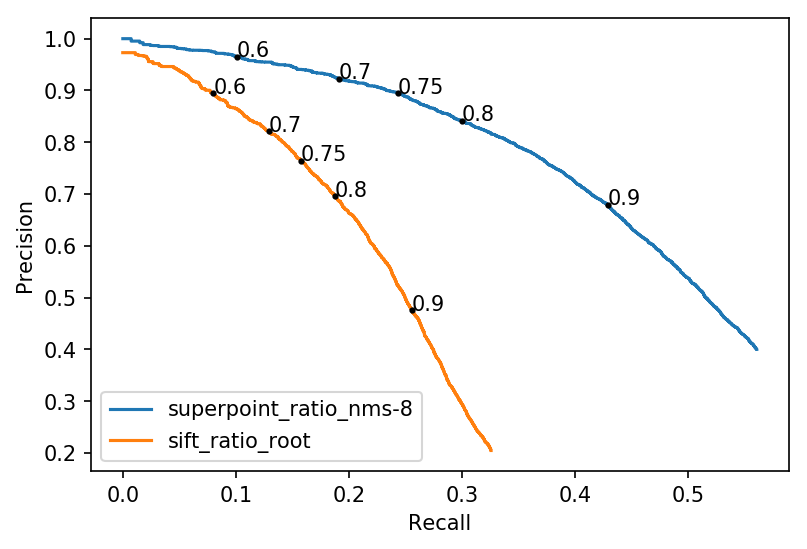

# Metric-scale evaluation of the pose estimation

500it [03:17,  3.02it/s]

> sift_ratio_root
average_num_keypoints     1000.000
correctness               0.586
matching_score            0.192
mAP                       0.223
{'id': 'sift_ratio_root', 'predictor': <function sift_loader at 0x2b4cdc66fe18>, 'root': True, 'num_features': 1000, 'do_ratio_test': True, 'do_nms': False, 'nms_thresh': 4, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


500it [04:21,  2.34it/s]

> doap_ST-dense_hpatches_superpoint_nms-8_ratio
average_num_keypoints     707.061
correctness               0.570
matching_score            0.369
mAP                       0.471
{'id': 'doap_ST-dense_hpatches_superpoint_nms-8_ratio', 'experiment': 'doap/colmap_hpatches_ST-dense', 'predictor': <function export_loader at 0x2b4cdc6588c8>, 'keypoint_predictor': <function export_loader at 0x2b4cdc6588c8>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap', 'do_nms': True, 'nms_thresh': 8, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


500it [02:49,  4.36it/s]

> superpoint_ratio_nms-8
average_num_keypoints     707.061
correctness               0.542
matching_score            0.342
mAP                       0.405
{'id': 'superpoint_ratio_nms-8', 'experiment': 'super_point_pytorch/colmap', 'predictor': <function export_loader at 0x2b4cdc6588c8>, 'num_features': 1000, 'do_nms': True, 'nms_thresh': 8, 'do_ratio_test': True, 'binarize': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


# DOAP

550it [04:58,  2.17it/s]

> doap_dense_hpatches_superpoint
average_num_keypoints     828.634
correctness               0.756
matching_score            0.379
mAP                       0.384
{'id': 'doap_dense_hpatches_superpoint', 'experiment': 'doap_dense_hpatches/colmap', 'predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [02:18,  5.37it/s]


> doap_dense_hpatches_superpoint_nms-8
average_num_keypoints     686.533
correctness               0.767
matching_score            0.363
mAP                       0.397
{'id': 'doap_dense_hpatches_superpoint_nms-8', 'experiment': 'doap_dense_hpatches/colmap', 'predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 8, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [04:10,  2.64it/s]

> doap_dense_liberty_superpoint
average_num_keypoints     828.634
correctness               0.716
matching_score            0.321
mAP                       0.269
{'id': 'doap_dense_liberty_superpoint', 'experiment': 'doap_dense_liberty/colmap', 'predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [04:08,  2.65it/s]

> doap_dense_hpatches_sift
average_num_keypoints     1000.000
correctness               0.664
matching_score            0.296
mAP                       0.299
{'id': 'doap_dense_hpatches_sift', 'experiment': 'doap_dense_hpatches/colmap', 'predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_predictor': <function sift_loader at 0x2ad3b76450d0>, 'keypoint_config': {'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [02:23,  5.32it/s]


> doap_dense_hpatches_superpoint_nms-8_ratio
average_num_keypoints     686.533
correctness               0.767
matching_score            0.363
mAP                       0.466
{'id': 'doap_dense_hpatches_superpoint_nms-8_ratio', 'experiment': 'doap_dense_hpatches/colmap', 'predictor': <function export_loader at 0x2b5c880b0950>, 'keypoint_predictor': <function export_loader at 0x2b5c880b0950>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 8, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [02:24,  5.08it/s]


> doap_dense_hpatches_superpoint_nms-4_ratio
average_num_keypoints     828.634
correctness               0.756
matching_score            0.379
mAP                       0.446
{'id': 'doap_dense_hpatches_superpoint_nms-4_ratio', 'experiment': 'doap_dense_hpatches/colmap', 'predictor': <function export_loader at 0x2b5c880b0950>, 'keypoint_predictor': <function export_loader at 0x2b5c880b0950>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [02:46,  4.54it/s]

> doap_dense-no-ST_hpatches_superpoint_nms-4_ratio
average_num_keypoints     828.634
correctness               0.640
matching_score            0.239
mAP                       0.221
{'id': 'doap_dense-no-ST_hpatches_superpoint_nms-4_ratio', 'experiment': 'doap/colmap_hpatches_dense', 'predictor': <function export_loader at 0x2b6208d60950>, 'keypoint_predictor': <function export_loader at 0x2b6208d60950>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [03:00,  4.21it/s]

> doap_dense-no-ST_hpatches_superpoint_nms-8_ratio
average_num_keypoints     686.533
correctness               0.618
matching_score            0.233
mAP                       0.239
{'id': 'doap_dense-no-ST_hpatches_superpoint_nms-8_ratio', 'experiment': 'doap/colmap_hpatches_dense', 'predictor': <function export_loader at 0x2b6208d60950>, 'keypoint_predictor': <function export_loader at 0x2b6208d60950>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 8, 'keypoint_predictor': None}, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


# NetVLAD

550it [06:13,  1.73it/s]

> netvlad_conv3-3_dist_1000-kpts-sp
average_num_keypoints     828.634
correctness               0.751
matching_score            0.320
mAP                       0.262
{'id': 'netvlad_conv3-3_dist_1000-kpts-sp', 'experiment': 'netvlad/colmap', 'predictor': <function export_loader at 0x2ad38a23f620>, 'num_features': 1000, 'keypoint_predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [03:05,  3.35it/s]

> netvlad_conv3-3_dist_1000-kpts-sp
average_num_keypoints     828.634
correctness               0.745
matching_score            0.279
mAP                       0.194
{'id': 'netvlad_conv3-3_dist_1000-kpts-sp', 'experiment': 'netvlad/colmap', 'predictor': <function export_loader at 0x2ad38a23f620>, 'num_features': 1000, 'keypoint_predictor': <function export_loader at 0x2ad38a23f620>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'do_ratio_test': False, 'binarize': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


# LF-Net

550it [01:24, 10.60it/s]


> lfnet_dist
average_num_keypoints     1000.000
correctness               0.631
matching_score            0.205
mAP                       0.078
{'id': 'lfnet_dist', 'experiment': 'lfnet/colmap_all_kpts-1000', 'predictor': <function export_loader at 0x2aff7ff6c9d8>, 'num_features': 1000, 'do_ratio_test': False, 'do_nms': False, 'nms_thresh': 8, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [01:24,  6.53it/s]

> lfnet_dist
average_num_keypoints     919.973
correctness               0.667
matching_score            0.202
mAP                       0.078
{'id': 'lfnet_dist', 'experiment': 'lfnet/colmap_all_kpts-1000', 'predictor': <function export_loader at 0x2aff7ff6c9d8>, 'num_features': 1000, 'do_ratio_test': False, 'do_nms': True, 'nms_thresh': 4, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [01:20, 11.22it/s]

> lfnet_ratio
average_num_keypoints     1000.000
correctness               0.631
matching_score            0.205
mAP                       0.186
{'id': 'lfnet_ratio', 'experiment': 'lfnet/colmap_all_kpts-1000', 'predictor': <function export_loader at 0x2aff7ff6c9d8>, 'num_features': 1000, 'do_ratio_test': True, 'do_nms': False, 'nms_thresh': 8, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


# SuperPoint

550it [01:46,  7.96it/s]

> superpoint_dist_nms-4
average_num_keypoints     828.634
correctness               0.718
matching_score            0.346
mAP                       0.322
{'id': 'superpoint_dist_nms-4', 'experiment': 'super_point_pytorch/colmap_all', 'predictor': <function export_loader at 0x2aff7ff6c9d8>, 'num_features': 1000, 'do_nms': True, 'nms_thresh': 4, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [01:47,  7.11it/s]

> superpoint_ratio_nms-4
average_num_keypoints     828.634
correctness               0.718
matching_score            0.346
mAP                       0.372
{'id': 'superpoint_ratio_nms-4', 'experiment': 'super_point_pytorch/colmap_all', 'predictor': <function export_loader at 0x2aff7ff6c9d8>, 'num_features': 1000, 'do_nms': True, 'nms_thresh': 4, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [01:39,  8.27it/s]

> superpoint_dist_nms-8
average_num_keypoints     686.533
correctness               0.744
matching_score            0.337
mAP                       0.343
{'id': 'superpoint_dist_nms-8', 'experiment': 'super_point_pytorch/colmap_all', 'predictor': <function export_loader at 0x2aff7ff6c9d8>, 'num_features': 1000, 'do_nms': True, 'nms_thresh': 8, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [01:47,  7.58it/s]

> superpoint_ratio_nms-8
average_num_keypoints     686.533
correctness               0.744
matching_score            0.337
mAP                       0.403
{'id': 'superpoint_ratio_nms-8', 'experiment': 'super_point_pytorch/colmap_all', 'predictor': <function export_loader at 0x2b5c880b0950>, 'num_features': 1000, 'do_nms': True, 'nms_thresh': 8, 'do_ratio_test': True, 'binarize': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [03:46,  2.98it/s]

> superpoint_dist_nms-4_harris
average_num_keypoints     980.197
correctness               0.620
matching_score            0.325
mAP                       0.265
{'id': 'superpoint_dist_nms-4_harris', 'experiment': 'super_point_pytorch/colmap_all', 'predictor': <function export_loader at 0x2aff7ff6c9d8>, 'num_features': 1000, 'keypoint_predictor': <function harris_loader at 0x2aff7ff6c950>, 'keypoint_config': {'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'do_nms': True, 'nms_thresh': 4, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


In [80]:
'binarized'

550it [01:34,  7.80it/s]

> superpoint_dist
average_num_keypoints     686.533
correctness               0.702
matching_score            0.310
mAP                       0.293
{'id': 'superpoint_dist', 'experiment': 'super_point_pytorch/colmap_all', 'predictor': <function export_loader at 0x2ad38a23f620>, 'num_features': 1000, 'do_nms': True, 'nms_thresh': 8, 'do_ratio_test': False, 'binarize': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


In [77]:
'binarized'

550it [01:55,  9.01it/s]


> superpoint_dist
average_num_keypoints     828.634
correctness               0.707
matching_score            0.316
mAP                       0.271
{'id': 'superpoint_dist', 'experiment': 'super_point_pytorch/colmap_all', 'predictor': <function export_loader at 0x2ad38a23f620>, 'num_features': 1000, 'do_nms': True, 'nms_thresh': 4, 'do_ratio_test': False, 'binarize': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


# SIFT

550it [03:26,  3.08it/s]

> sift_ratio
average_num_keypoints     1000.000
correctness               0.675
matching_score            0.178
mAP                       0.195
{'id': 'sift_ratio', 'predictor': <function sift_loader at 0x2aff7ff54ea0>, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [03:29,  2.98it/s]

> sift_ratio_root
average_num_keypoints     1000.000
correctness               0.713
matching_score            0.192
mAP                       0.224
{'id': 'sift_ratio_root', 'predictor': <function sift_loader at 0x2aff7ff54ea0>, 'root': True, 'num_features': 1000, 'do_ratio_test': True, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


550it [03:45,  3.01it/s]

> sift_ratio_root
average_num_keypoints     1000.000
correctness               0.695
matching_score            0.164
mAP                       0.184
{'id': 'sift_ratio_root', 'predictor': <function sift_loader at 0x2aff7ff54ea0>, 'root': True, 'num_features': 1000, 'do_ratio_test': True, 'do_nms': True, 'nms_thresh': 4, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


# MobilenetVLAD

550it [01:46,  7.03it/s]

> mobilenetvlad_L-14_dist_1000-kpts-sp
average_num_keypoints     828.634
correctness               0.435
matching_score            0.154
mAP                       0.057
{'id': 'mobilenetvlad_L-14_dist_1000-kpts-sp', 'experiment': 'mobilenetvlad_depth-0.35/colmap_layer-14', 'predictor': <function export_loader at 0x2aff7ff6c9d8>, 'num_features': 1000, 'keypoint_predictor': <function export_loader at 0x2aff7ff6c9d8>, 'keypoint_config': {'experiment': 'super_point_pytorch/colmap_all', 'do_nms': True, 'nms_thresh': 4, 'keypoint_predictor': None}, 'do_ratio_test': False, 'correct_match_thresh': 5, 'correct_trans_thresh': 1, 'correct_rot_thresh': 1, 'plot_match_thresh': [0.9, 0.8, 0.75, 0.7, 0.6]}


# PR Curves

In [ ]:
plt.figure(dpi=150)
plt.plot(recall, precision);
plt.xlabel('Recall'), plt.ylabel('Precision'); plt.title(config['id']);
for t in config['plot_match_thresh']:
    op_idx = np.min(np.where(distances > t))
    plt.plot(recall[op_idx], precision[op_idx], marker='o', color='k', markersize=3)
    plt.annotate(str(t), xy=(recall[op_idx], precision[op_idx]))

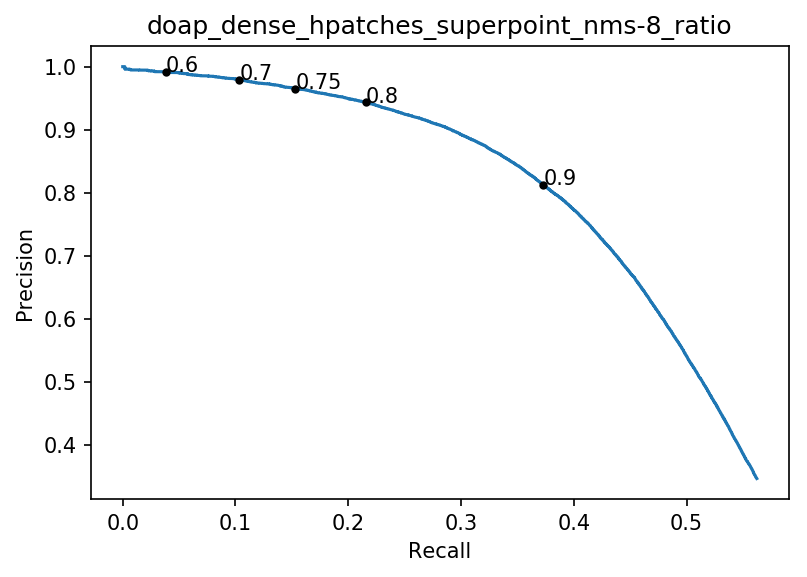

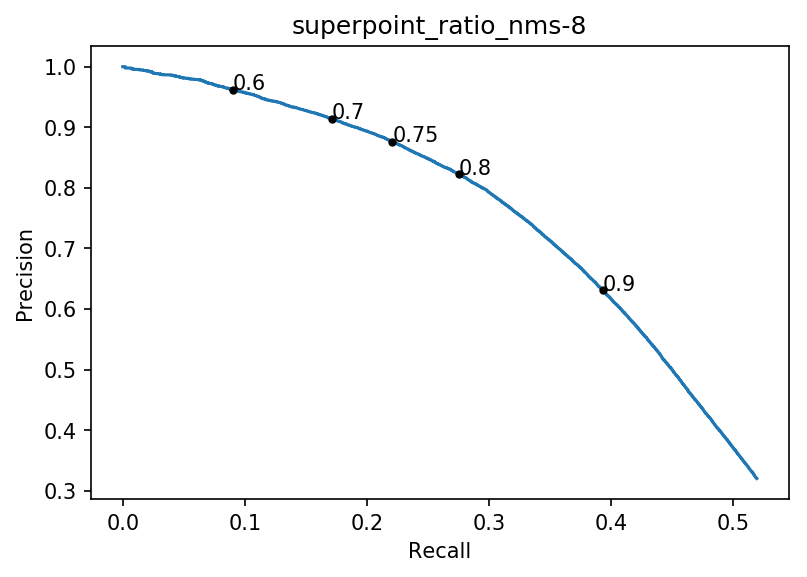

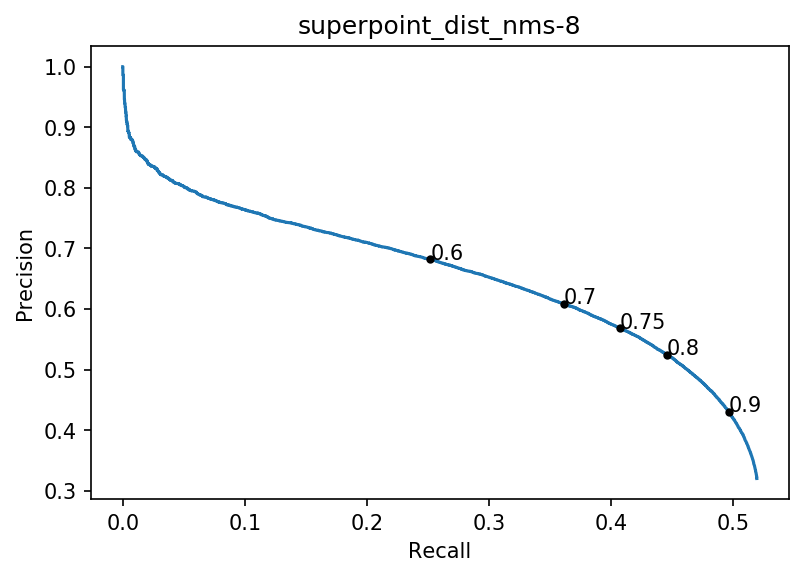